In [1]:
"""Cell 1: Generate a ground truth grid."""

import sys
sys.path.insert(0, "..")

import numpy as np
import torch
import matplotlib.pyplot as plt
from data_processing import get_nfv_dataset, preprocess_wavefront_data

# Grid parameters
nx, nt = 50, 250
dx, dt = 0.02, 0.004
max_steps = 3  # number of pieces in piecewise-constant IC

np.random.seed(42)
grids = get_nfv_dataset(
    n_samples=5, nx=nx, nt=nt, dx=dx, dt=dt,
    max_steps=max_steps, only_shocks=True,
)
processed = preprocess_wavefront_data(grids, nx, nt, dx, dt)

# Pick one sample
sample_idx = 0
input_data, target_grid = processed[sample_idx]  # target_grid: (1, nt, nx)
grid = target_grid.squeeze(0)  # (nt, nx)

# Coordinate arrays for plotting
x = np.arange(nx) * dx
t = np.arange(nt) * dt

print(f"Grid shape: {grid.shape}")
print(f"x range: [{x[0]:.3f}, {x[-1]:.3f}], t range: [{t[0]:.3f}, {t[-1]:.3f}]")
print(f"Density range: [{grid.min():.3f}, {grid.max():.3f}]")

/Users/mchami/ETH/Thesis/saint-venant/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2it [00:00, 13.24it/s]                       

Grid shape: torch.Size([250, 50])
x range: [0.000, 0.980], t range: [0.000, 0.996]
Density range: [0.375, 0.951]


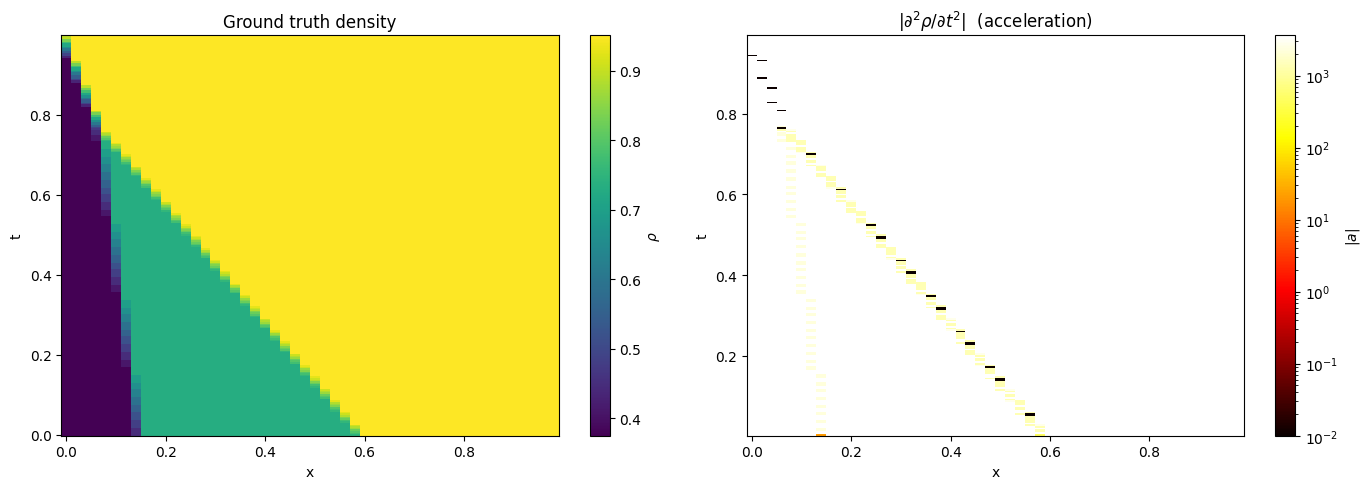

Acceleration shape: torch.Size([248, 50])
Max |accel|: 3601.09, Mean |accel|: 46.16


In [6]:
"""Cell 2: Acceleration grid vs ground truth."""

from losses.acceleration import compute_acceleration

# Compute acceleration: (1, nt, nx) -> (1, nt-2, nx)
accel = compute_acceleration(grid.unsqueeze(0), dt).squeeze(0)  # (nt-2, nx)

# Interior time array (drops first and last time step)
t_interior = t[1:-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ground truth density
im0 = axes[0].pcolormesh(x, t, grid.numpy(), shading="auto", cmap="viridis")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title("Ground truth density")
fig.colorbar(im0, ax=axes[0], label=r"$\rho$")

# Acceleration (log scale of absolute value for visibility)
accel_abs = accel.abs().numpy()
im1 = axes[1].pcolormesh(
    x, t_interior, accel_abs,
    shading="auto", cmap="hot",
    norm=plt.matplotlib.colors.LogNorm(
        vmin=max(accel_abs[accel_abs > 0].min(), 1e-2),
        vmax=accel_abs.max(),
    ),
)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title(r"$|\partial^2 \rho / \partial t^2|$  (acceleration)")
fig.colorbar(im1, ax=axes[1], label=r"$|a|$")

fig.tight_layout()
plt.show()

print(f"Acceleration shape: {accel.shape}")
print(f"Max |accel|: {accel_abs.max():.2f}, Mean |accel|: {accel_abs.mean():.2f}")

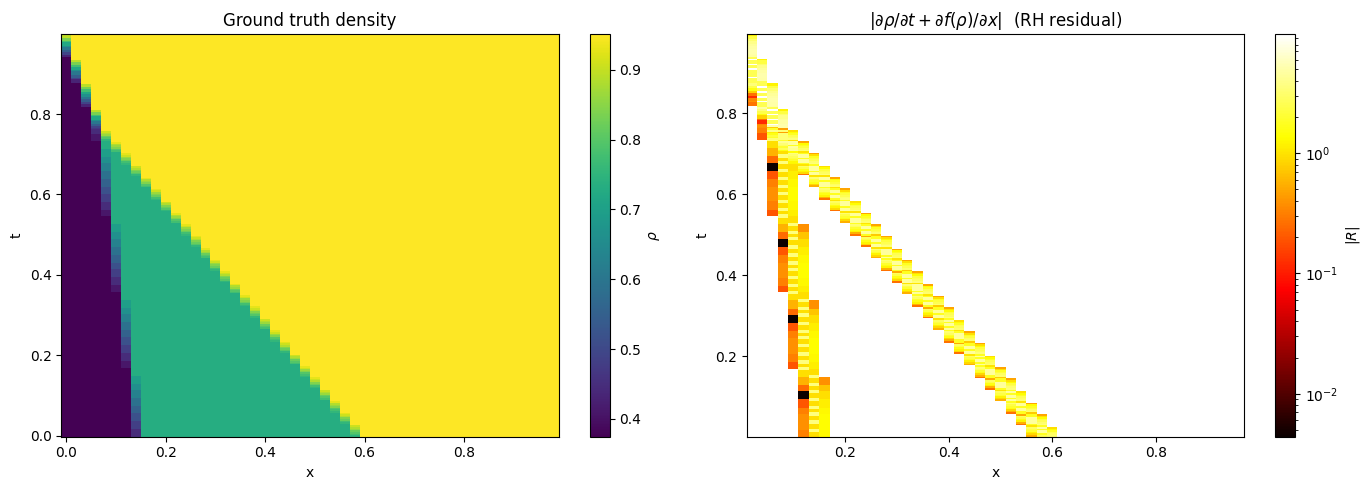

RH residual shape: torch.Size([248, 48])
Max |R|: 9.7193, Mean |R|: 0.1936


In [8]:
"""Cell 3: RH / conservation residual grid vs ground truth.

At each interior cell we compute the PDE residual:
    R = d rho / dt + d f(rho) / dx
where f(rho) = rho * (1 - rho)  (Greenshields flux).

In smooth regions R ~ 0. At shocks the pointwise PDE breaks down
and R is large -- these are exactly the locations where the
Rankine-Hugoniot jump condition governs the solution.
"""

from losses.pde_residual import compute_pde_residual

# Compute RH / conservation residual: (1, nt, nx) -> (1, nt-2, nx-2)
rh_res = compute_pde_residual(grid.unsqueeze(0), dt, dx).squeeze(0)  # (nt-2, nx-2)

# Interior coordinate arrays
x_interior = x[1:-1]
t_interior = t[1:-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ground truth density
im0 = axes[0].pcolormesh(x, t, grid.numpy(), shading="auto", cmap="viridis")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title("Ground truth density")
fig.colorbar(im0, ax=axes[0], label=r"$\rho$")

# RH residual (log scale of absolute value)
rh_abs = rh_res.abs().numpy()
im1 = axes[1].pcolormesh(
    x_interior, t_interior, rh_abs,
    shading="auto", cmap="hot",
    norm=plt.matplotlib.colors.LogNorm(
        vmin=max(rh_abs[rh_abs > 0].min(), 1e-4),
        vmax=rh_abs.max(),
    ),
)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title(
    r"$|\partial\rho/\partial t + \partial f(\rho)/\partial x|$"
    "  (RH residual)"
)
fig.colorbar(im1, ax=axes[1], label=r"$|R|$")

fig.tight_layout()
plt.show()

print(f"RH residual shape: {rh_res.shape}")
print(f"Max |R|: {rh_abs.max():.4f}, Mean |R|: {rh_abs.mean():.4f}")

Found 2 discontinuities in the IC:
  d=0: x0=0.150, rho_L=0.446, rho_R=0.732, s_RH=-0.178
  d=1: x0=0.590, rho_L=0.747, rho_R=0.951, s_RH=-0.697


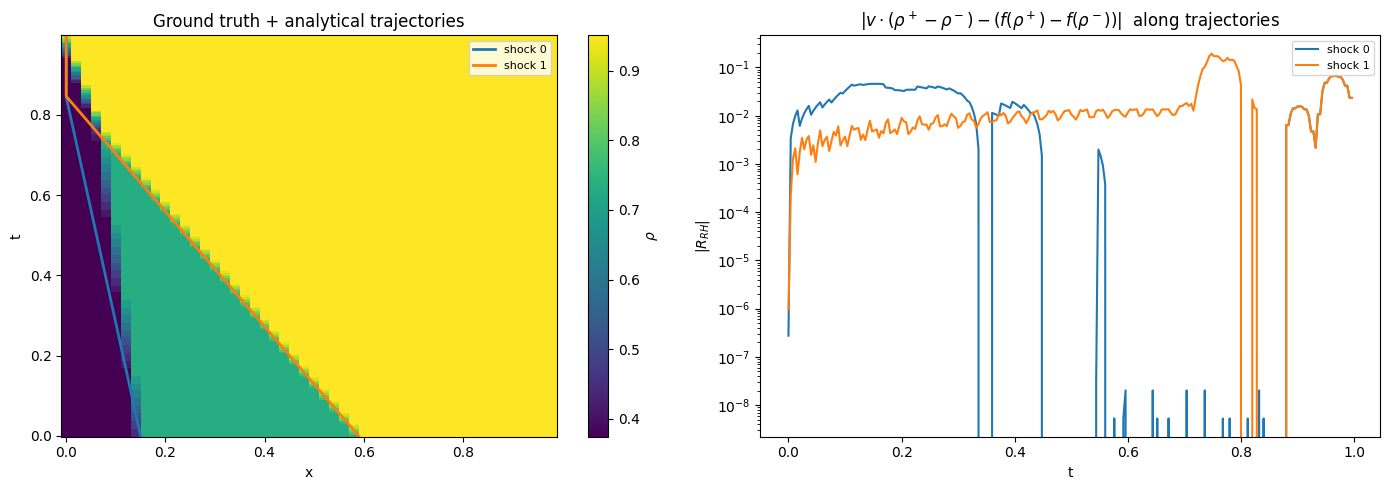

Residual shape: torch.Size([2, 250])  (n_disc, nt)
  shock 0: max |R|=0.067599, mean |R|=0.014758
  shock 1: max |R|=0.194267, mean |R|=0.020129


In [9]:
"""Cell 4: RH residual along analytical shock trajectories (rh_residual.py).

Uses compute_shock_velocity, sample_density_from_grid, and greenshields_flux
from rh_residual.py exactly as the loss does during training.

Steps:
1. Extract discontinuities from the IC (x0, rho_L, rho_R)
2. Build analytical shock trajectories: x_d(t) = x0 + s_d * t
   where s_d = 1 - rho_L - rho_R  (Greenshields RH speed)
3. compute_shock_velocity  -> finite-difference velocity from positions
4. sample_density_from_grid -> u_minus, u_plus at trajectory +/- epsilon
5. RH residual = v * (u+ - u-) - (f(u+) - f(u-))
"""

from losses.rh_residual import compute_shock_velocity, sample_density_from_grid
from losses.flux import greenshields_flux, compute_shock_speed

# -- 1. Extract discontinuities from the IC ----------------------------------
disc = input_data["discontinuities"]  # (max_disc, 3): [x, rho_L, rho_R]
disc_mask_vec = input_data["disc_mask"]  # (max_disc,)
n_disc = int(disc_mask_vec.sum().item())

print(f"Found {n_disc} discontinuities in the IC:")
for d in range(n_disc):
    x0, rL, rR = disc[d].tolist()
    s = 1.0 - rL - rR
    print(f"  d={d}: x0={x0:.3f}, rho_L={rL:.3f}, rho_R={rR:.3f}, s_RH={s:.3f}")

# -- 2. Build analytical shock trajectories -----------------------------------
t_arr = torch.arange(nt).float() * dt  # (nt,)
positions = torch.zeros(1, n_disc, nt)  # (B=1, D, T)
for d in range(n_disc):
    x0 = disc[d, 0]
    rho_L, rho_R = disc[d, 1], disc[d, 2]
    s_d = 1.0 - rho_L - rho_R
    positions[0, d, :] = (x0 + s_d * t_arr).clamp(0.0, 1.0)

# -- 3-5. Compute RH residual using rh_residual.py functions -----------------
x_coords = input_data["x_coords"].unsqueeze(0)  # (1, 1, nt, nx)
target = target_grid.unsqueeze(0)  # (1, 1, nt, nx)

velocities = compute_shock_velocity(positions, dt)  # (1, D, T)

epsilon_rh = 0.01
u_minus, u_plus = sample_density_from_grid(
    target, positions, x_coords, max_d=n_disc, epsilon=epsilon_rh,
)  # each (1, D, T)

f_minus = greenshields_flux(u_minus)
f_plus = greenshields_flux(u_plus)

residual = velocities[:, :n_disc, :] * (u_plus - u_minus) - (f_plus - f_minus)
residual = residual.squeeze(0)  # (D, T)

# -- Plot ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: GT grid with trajectory lines overlaid
im0 = axes[0].pcolormesh(x, t, grid.numpy(), shading="auto", cmap="viridis")
colors = plt.cm.tab10.colors
for d in range(n_disc):
    traj = positions[0, d, :].numpy()
    axes[0].plot(traj, t, color=colors[d % len(colors)], linewidth=2,
                 label=f"shock {d}")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title("Ground truth + analytical trajectories")
axes[0].legend(loc="upper right", fontsize=8)
fig.colorbar(im0, ax=axes[0], label=r"$\rho$")

# Right: |RH residual| along each trajectory vs time
for d in range(n_disc):
    axes[1].plot(t, residual[d].abs().detach().numpy(),
                 color=colors[d % len(colors)], linewidth=1.5,
                 label=f"shock {d}")
axes[1].set_xlabel("t")
axes[1].set_ylabel(r"$|R_{RH}|$")
axes[1].set_title(
    r"$|v \cdot (\rho^+ - \rho^-) - (f(\rho^+) - f(\rho^-))|$"
    "  along trajectories"
)
axes[1].legend(fontsize=8)
axes[1].set_yscale("log")

fig.tight_layout()
plt.show()

print(f"Residual shape: {residual.shape}  (n_disc, nt)")
for d in range(n_disc):
    r = residual[d].abs()
    print(f"  shock {d}: max |R|={r.max():.6f}, mean |R|={r.mean():.6f}")